In [4]:
# Imports
import gym
import QDgym_extended
import numpy as np
import scipy.ndimage as ndimage
from util import modify, calculate_arc
import matplotlib.pyplot as plt


def decode_genotype(genotype):
    """genotype: shape (24,) array, 3 parameters for each of the 8 motors.
    each motor genotype in the form of (duty_cycle, phase, scale).

    duty_cycle : [0, 1)
    phase: [0, 1)
    scale: [0, 1]
    """
    
    targets = -np.ones((100, 8), dtype=np.float32)
    phase = np.int32(genotype[1::3] * 100)
    for index, duty_cycle in enumerate(genotype[0::3]):
        start = phase[index]
        end = int(duty_cycle*101) + start
        targets[start: end, index] = 1
        if end > 100:
            targets[: end-100, index] = 1

    guassian_kernel = np.array([0.0008880585, 0.0015861066, 0.00272177, 0.00448744, 0.007108437, 0.010818767, 
                                0.015820118, 0.022226436, 0.03000255, 0.03891121, 0.048486352, 0.058048703, 
                                0.0667719, 0.073794365, 0.078357555, 0.07994048, 0.078357555, 0.073794365, 
                                0.0667719, 0.058048703, 0.048486352, 0.03891121, 0.03000255, 0.022226436, 
                                0.015820118, 0.010818767, 0.007108437, 0.00448744, 0.00272177, 0.0015861066, 
                                0.0008880585], dtype=np.float32)

    targets = ndimage.convolve1d(targets, guassian_kernel, axis=0, mode="wrap")
    
    scales = np.float32(genotype[2::3])
    return targets, scales


In [5]:
# Make environment
# env = gym.make("QDDeterministicWalker2DBulletEnv-v0")
# env = gym.make("QDAntOmnidirectionalBulletEnv-v0")

modify(10, 1.0)
env = gym.make("QDCustomAntBulletEnv-v0", robot_file="custom_ant.xml")

# Reset environment

state = env.reset()
done = False

n = 0

# genotype = np.ones(24)
# genotype[1::3] = 0
# genotype[0::3] = 0.7

genotype = np.random.uniform(0, 1, (24))
genotype = np.array([0.259303, 0.635747, 0.798838, 0.734469, 
                     0.777344, 0.042424, 0.250724, 0.482677, 
                     0.862689, 0.476355, 0.0, 0.478584, 
                     0.631273, 0.484417, 0.735959, 0.311633, 
                     0.834801, 0.807166, 0.43869, 0.129341, 
                     0.106889, 0.217222, 0.810687, 0.548715])

# genotype = np.array([0.5968, 0.725634, 0.9999, 0.31895, 
#                      0.156913, 0.357329, 0.744598, 0.168164, 
#                      0.016688, 0.598645, 0.225869, 0.70942, 
#                      0.661377, 0.307844, 0.778356, 0.734412, 
#                      0.628775, 0.103119, 0.75821, 0.801563, 
#                      0.140996, 0.538683, 0.261772, 0.493624])

targets, scales = decode_genotype(genotype)



kds = np.array([0.072, 0.082, 0.072, 0.082, 0.072, 0.082, 0.072, 0.082], dtype=np.float32)
kps = np.array([1.43, 1.637, 1.43, 1.637, 1.43, 1.637, 1.43, 1.637], dtype=np.float32)
constants = np.array([0.0, 1.857176, 0.0, -1.857176, 0.0, -1.857176, 0.0, 1.857176], dtype=np.float32)

positions = np.zeros(8, dtype=np.float32)
speeds = np.zeros(8, dtype=np.float32)
for index, joint in enumerate(env.ordered_joints):
    positions[index], speeds[index] = joint.current_position()

# calculate offset
# offset = np.argmin(np.sum(np.square(constants + scales*targets - positions*kps), axis=1))
# print("offset", offset)

xy = np.zeros((1000, 2))

# Evaluation loop
# while not done:
for i in range(1000):
    # target = targets[(n + offset)% 100]
    target = targets[n % 100]
    for index, joint in enumerate(env.ordered_joints):
        positions[index], speeds[index] = joint.current_position()

    # target[1] = -1
    # target[3] = 1
    # target[5] = 1
    # target[7] = -1

    target[1] = 0.8
    target[3] = -0.8
    target[5] = -0.8
    target[7] = 0.8

    target[1] = -1
    # target[3] = 1
    # target[5] = 1
    # target[7] = -1


    # target[: : 2] = 0
    action = np.clip(constants + scales*target - positions*kps - kds*speeds, -1, 1)

    # action[:2] = 0
    # action[6] = 0
    # action = np.zeros(8)

    # state, reward, done, info = env.step(action * np.random.uniform(0.8, 1.0, 8))
    state, reward, done, info = env.step(action)

    x, y, z = env.robot_body.pose().xyz()
    xy[n, 0] = x
    xy[n, 1] = y

    n += 1
    if n == 420:
        print(done)
        break

    

# print("attr:", (env._render_width, env._render_height))

# print("step length:", n)

# Get final fitness and BD
fitness = env.tot_reward
behaviour_descriptor = env.desc # alternatively behaviour_descriptor = info["bc"] for compatability with the code released for MAP-Elites-ES


# Close environment
print("length:", n)

argv[0]=
argv[0]=
False
length: 420


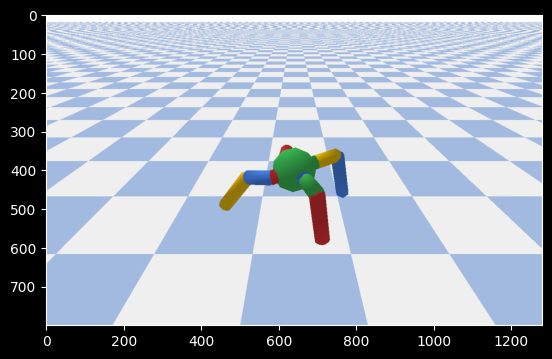

In [6]:

image = env.render(mode="rgb_array")
plt.imshow(image)
# plt.savefig("damaged.pdf", dpi=500)
# plt.savefig("intact.pdf", dpi=500)
# np.save("intact.npy", image)
# np.save("damaged.npy", image)
plt.show()
env.close()


In [7]:
# np.save("damaged.npy", image)